In [1]:
!git clone https://github.com/kushalvyas/alpine.git
%cd alpine
!pip3 install -e .

Cloning into 'alpine'...
remote: Enumerating objects: 854, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 854 (delta 95), reused 112 (delta 83), pack-reused 679 (from 1)
Receiving objects: 100% (854/854), 11.82 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (450/450), done.
/content/alpine
Obtaining file:///content/alpine
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.2 MB/s eta 0:00:

In [2]:
import torch
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics import MetricTracker

from matplotlib import pyplot as plt
from tqdm import tqdm
import skimage.transform

import alpine
from alpine.models import Gauss
from alpine.metrics import SSIM
from alpine.models.utils import get_coords_spatial

/content/alpine/alpine/models/siren.py:96: SyntaxWarning: invalid escape sequence '\c'
  coords (torch.Tensor): Input coordinates or features to the model of shape :math:`b \\times \cdots \\times d` where b is batch and d is the number of input features.
/content/alpine/alpine/models/strainer.py:104: SyntaxWarning: invalid escape sequence '\c'
  coords (torch.Tensor): Input coordinates or features to the model of shape :math:`b \\times \cdots \\times d` where b is batch and d is the number of input features.
/content/alpine/alpine/models/wire.py:97: SyntaxWarning: invalid escape sequence '\c'
  coords (torch.Tensor): Input coordinates or features to the model of shape :math:`b \\times \cdots \\times d` where b is batch and d is the number of input features.
/content/alpine/alpine/models/ffn.py:95: SyntaxWarning: invalid escape sequence '\c'
  coords (torch.Tensor): Input coordinates or features to the model of shape :math:`b \\times \cdots \\times d` where b is batch and d is the numbe

Using device: cuda


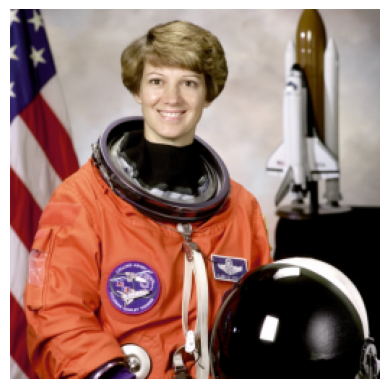

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

img_res = (256, 256) # Image resolution

gt_img = skimage.transform.resize(skimage.data.astronaut(), img_res)
gt = torch.from_numpy(gt_img).float().to(device)

image_cpu = gt.cpu().numpy()
plt.imshow(image_cpu)
plt.axis('off')
plt.show()

In [4]:
coords = get_coords_spatial(img_res[0], img_res[1]).to(device)[None, ...] # Get coordinate grid and add batch dim
print(f"Coordinates shape: {coords.shape}")

Coordinates shape: torch.Size([1, 256, 256, 2])


/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
gauss_model = Gauss(in_features=2, out_features=3, hidden_features=256, hidden_layers=3).to(device)
print(gauss_model)
gauss_model.compile()

Gauss(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (model): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Gauss()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Gauss()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [8]:
epochs = 5000

In [9]:
outputs = gauss_model.fit_signal(input=coords, signal=gt, n_iters=epochs, enable_tqdm=True, return_features=True, 
                                    metric_trackers = {'psnr': MetricTracker(PeakSignalNoiseRatio(data_range=1.0).to(device)), 
                                                       'ssim' : MetricTracker(alpine.metrics.SSIM(signal_shape=img_res).to(device))
                                                       }, 
                                    track_loss_history=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

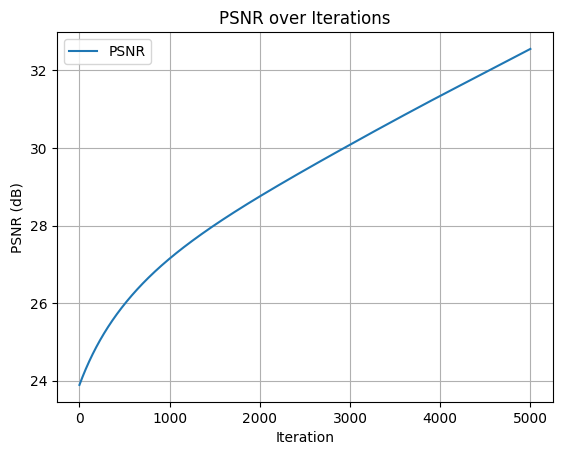

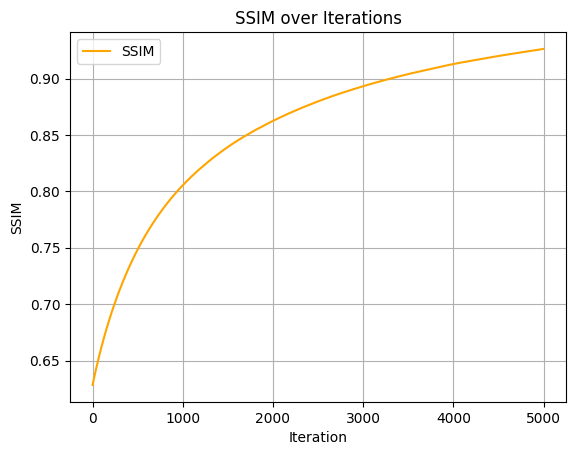

In [10]:
output = outputs['output']
all_metrics = outputs['metrics']

# Plot psnr
plt.plot(all_metrics['psnr'], label='PSNR')
plt.xlabel('Iteration')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations')
plt.legend()
plt.grid()
plt.show()

# Plot ssim
plt.plot(all_metrics['ssim'], label='SSIM', color='orange')
plt.xlabel('Iteration')
plt.ylabel('SSIM')
plt.title('SSIM over Iterations')
plt.legend()
plt.grid()
plt.show()

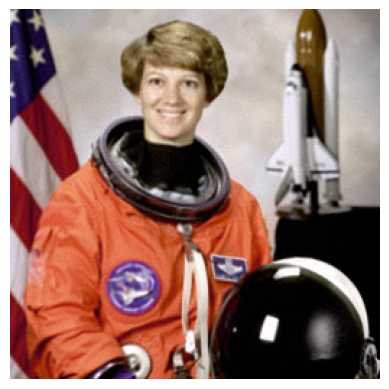

In [11]:
plt.figure()
plt.imshow(output.cpu().detach().numpy().reshape(256,256,3).clip(0,1))
plt.axis('off')
plt.show()